# Model Background

This section includes conceptual details for the emulator.

Sources I used for this build: 

1. [Wikipedia](https://www.wikipedia.org/)- Probably the most important source. Most of this stuff has excellent and detailed wikipages.
2. The book [Electronic Circuits Demystified](https://www.amazon.com/Circuit-Analysis-Demystified-David-McMahon/dp/0071488987) by David McMahon is absolutely fantastic.
3. The book [Differential Equations Demystified](https://www.amazon.com/gp/product/0071440259?ref_=dbs_m_mng_rwt_calw_tpbk_4&storeType=ebooks) by Steven Krantz was extremely helpful for the analog mathematics.
4. [ChatGPT](https://openai.com/index/chatgpt/). I mostly used the 4o model for development assistance, and the o4-mini-high model for Python code debugging. I could have made this without GPT, but it would have taken about 100X longer. GPT was extremely helpful for initial designing of pseudocode for the emulator and debugging my fat-fingered syntax errors. 

## Modified Nodal Analysis

This program is based on [MNA](https://en.wikipedia.org/wiki/Modified_nodal_analysis), a linear approximation of analog circuit behavior. It involves systematic calculation of voltages at nodes in the circuit using Kirchoff's laws. We begin with [Ohm's law](https://en.wikipedia.org/wiki/Ohm's_law): 
$$
V=I\,R
$$
where $V$ is voltage (potential), $I$ is current, and $R$ is resistance. Ohm's law tells us that the current between two conductors is proportional to the difference in voltage across the two points. 

We use nodal form to set up the framework for dealing with many currents, voltages, and resistances distributed over a circuit. A node is a device on the circuit, for example, a resistor. Devices are connected together to make more complex circuits. 

Note that conductance $G$ (sometimes called 'admittance') is the inverse of resistance ($1/R$). So we have: 
$$
I=V\,G
$$

It's important to know that circuit diagrams are referenced in the direction of positive flow by convention, thus the region of largest potential is the cathode, and the lowest potential is the anode. Of course, this is backward from the actual electron flow. Mathematically, this doesn't matter, it just sets up the sign convention for each expression. 

In this model, the voltage is fixed between two nodes. The highest potential is at the positive pole of the voltage source (a.k.a. emf) and the lowest potential is at the ground. For example if the voltage source is a battery, the ground is the anode. Apparently, the ground can be any reference point in the circuit, but is always given a zero voltage. 

MNA is a linear analysis where: 
$$
G\cdot x= I
$$

where $G$ is the `conductance matrix` that captures all of the constraints in the circuit (e.g., ohmic resistance). $x$ is a `vector of unknowns`, including voltages at each node and currents through voltage sources. $I$ is the `source vector`, including known voltage sources and currents. 

There are two important relations to keep in mind: 
1. Kirchoff's Current Law- states that the sum of currents at any node must equal 0. That is, the currents are signed. If $+1$ comes in $-1$ must leave.  This is similar to the mass balance constraint in metabolic flux analysis. 
2. Kirchoff's Voltage Law- states that within a closed loop, the total voltage sums to the voltage at the power source. In other words, the sum of voltage drops = the sum of voltage rises. 

## A Simple Circuit with Two Resistors in Sequence

We'll start with a simple divider circuit with one voltage source 'V+' applying a 5.0 V potential from the positive pole 'V+' to the negative pole (ground; 'GND'). There is one resistance (1000$\Omega$), and arbitrary output device 'OUT', and a second (2000$\Omega$) resistance. All together: 

V+ -> Resistance -> OUT -> Resistance -> GND

Let V+ = $V_1$, OUT = $V_2$, and the current through the voltage source = $I_s$.

In nodal analysis we want to know: "What is the voltage at each node?"

KCL states that current can't accumulate, what comes into a node, must leave a node in equal proportion. KVL states that the potential in the circuit can't exceed the source (can't invent energy you don't have). 

The first equation of interest applies these laws from the first node to the second, i.e., V+ -> R1 -> OUT. In other words, we want to know the current from the source, through the first resistor to the OUT device; and we want to know what effect the resistance has on the voltage at the OUT node. Recall that $V\,G=I$. Through R1, suppose the conductance is $\frac{1}{1000}(\Omega)$. So the total current is the difference in current across the resistor. 
$$
I_s= I_{s} - I_{OUT} = V_1\frac{1}{1000} - V_2\frac{1}{1000}
$$

KCL states that the total current at any node must be $0$, so, this gives us the first of three linear equations in the system. It describes the current through resistance R1 and the current through the voltage source. It is of the form:
$$
\frac{V_1-V_2}{1000} - I_s = 0
$$

When arranging the terms, think about it like summing the nodes. If 'away from the node' is positive by convention, 'to the node' is negative. So to go from V+ to OUT, we sum the currents which are given by $+V_1\,\frac{1}{R1}$ and $-V_2\,\frac{1}{R1})$. In other words, the sum of the currents through the voltage source and through its connected resistor must be zero. Current in, current out. Now, in order to solve this in matrix form later, we need to be able to separate the unknowns, so we rearrange as follows: 

$$
V_1\,\frac{1}{1000} - V_2\,\frac{1}{1000} - (1)I_s = 0
$$

This will give us this nice vector of unknowns $x$: 

$$
x= \begin{bmatrix} 
V_1 \\ 
V_2 \\ 
I_s 
\end{bmatrix}
$$

Next, we formulate an equation for the current from OUT -> R2 -> GND. This is the second linear equation of the form: 
$$
\frac{V_2-V_1}{1000} + \frac{V_2 - 0}{2000} - (0)\,I_s = 0 
$$

The left term is the current through R1 (notice that is has the opposite sign of the expression in the first equation), the second term is the current through R2. Recall that the GND always has a potential of 0 V. The third term is a placeholder for the unknown current through the source, but is simply 0 here.

Again, to write this in matrix form for the whole system, each term can only have one variable, so we rearrange as follows: 
$$
-V_1\,\frac{1}{1000} + V_2\,(\frac{1}{1000} + \frac{1}{2000}) - (0)\,I_s = 0
$$

The final equation in the system describes the total voltage constraint on the system. It is the voltage from source to GND. Suppose the source V_1 provides a step voltage of 5.0 V (step simply means that it goes instantaneously from 0.0 to 5.0 V).  

$$
V_1 - (0)\,V_2 - (0)\,I_s = 5
$$

Now we can put the whole thing in matrix form to solve for our three unknowns: 

$$
\begin{bmatrix}
\phantom{-}0.001 & -0.001  & -1     \\
-0.001  & \phantom{-}0.0015 & \phantom{-}0     \\
\phantom{-}1     & 0        & 0
\end{bmatrix}
\begin{bmatrix}
V_1 \\
V_2 \\
I_s
\end{bmatrix}
=
\begin{bmatrix}
0 \\
0 \\
5
\end{bmatrix}
$$

## Adding Dynamics

MNA described above only returns the distribution of voltages among the nodes at steaty state. To emulate analog computers, we need to model dynamic processes involving changes in voltage and/or current over time. To achieve this we'll add control flow to a new simulation function that enables calculating the MNA distribution for timesteps of a designated size. To solve, we'll use the [backward Euler method](https://en.wikipedia.org/wiki/Backward_Euler_method). 

Euler's method is a first order approximation of the characteristic curve, part of a bigger family of methods for solving differential equations called [Runge-Kutta](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) methods. The characteristic curve is estimated essentially by brute force, using initial values for time and $y(t)$ to sum the current value of the derivative and the product of the derivative with the time step $\Delta\,t$. When these are all put together. If plotted, this essentially shows a collection of the tangent lines at every timestep, as the timestep gets smaller, the resolution of the curve becomes more precise, approximating the solution to the differential equation(s). Choosing an appropriate timestep size is important, because it determines the resolution of the solving method. Higher order methods such as the mid-point method are more accurate, but more computationally intensive to solve, so Euler's method will work fine here. 

Forward vs. backward Euler depends on which timepoints are used to find the solution at each step. The backward method is useful here, because we will choose an initial state for the circuit and then 'back-calculate' from each previous step for each present step in time. Here's a more formal breakdown of the backward Euler method. Suppose we have a derivative: 

$$
\frac{dy}{dt}= f(t,y)
$$

with an initial value $Y(t_0)=y_0$. In our model the initial time $t_0$ and function value $y_0$ are known. Suppose we have a sequence $y_0, y_1, y_2, ... y_k$ and $y_k$ approximates $y\,(t_0+kh)$ where$h$ is the timestep size. the backward Euler method computes the approximation using: 

$$
y_{k+1}= y_k + h\,f(t_{k+1}, y_{k+1})
$$

This method is known as an implicit method, because $y_{k+1}$ appears on both sides of the equation. This is solvable because we know the time and the solution at every previous step. 

## A Very Brief Intro to Circuit Components

Now's a good time to give an overview of common [hardware components](https://en.wikipedia.org/wiki/Electronic_component) that are used in electrical circuits. There are two general types of hardware: 

1. Passive
2. Active

Within each of those categories there are two subtypes: 

1. Linear
2. Nonlinear

Some common linear passive devices: 

1. [Resistor](https://en.wikipedia.org/wiki/Resistor)- slows current. Similar to friction force. Lowers potential (voltage).
2. [Capacitor](https://en.wikipedia.org/wiki/Capacitor)- stores charge by separating between two closely spaced plates. also resists current relative to its ability to separate charge (capacitance).
3. [Inductor](https://en.wikipedia.org/wiki/Inductor)- resists a change in current by storing energy in a magnetic field as current flows through it.

A common nonlinear passive device: 

1. [Diode](https://en.wikipedia.org/wiki/Diode)- conducts current primarily in one direction. I.e. infinite resistance in one direction, zero resistance in the opposite direction.

A common non-linear active device:

1. [Transistor](https://en.wikipedia.org/wiki/Transistor)- induces variable resistance. Transisters are active devices that use an input current to amplify or switch an existing current. They are active because they require an external power source to perform their function. They also include or consist of diodes. Transistors come in two main types: [bipolar junction transistors](https://en.wikipedia.org/wiki/Bipolar_junction_transistor) and [field effect transistors](https://en.wikipedia.org/wiki/Field-effect_transistor).

With these devices above (excluding maybe the diode because this is less common), integrated circuits can be made that perform sophisticated analog computations, particularly in solving differential equations. A powerful form of integrated circuit is known as an [operational-amplifier](https://en.wikipedia.org/wiki/Operational_amplifier) or 'op-amp'. Op-amps can be built to perform characteristic operations such as integration, inversion, and summation. Operations can be strung together to make an analog circuit for general classes of functions. 

--- 
### Important Note

There is a difference in the methods used to solve linear vs. non-linear differential equations using the backward Euler method. When the components in the circuit are linear (i.e., resistor, capacitor, inductor) linear algebra solving methods such as Gaussian elimination can be used. If non-linear components are included (i.e., diode and/or transistor), a different solver method such as [Newton-Raphson method](https://en.wikipedia.org/wiki/Newton's_method) must be used. This method will be explained in more detail later when diodes are discussed. 

## The Resistor Capacitor (RC) Circuit

In this example, we'll build a simple analog [RC circuit](https://en.wikipedia.org/wiki/RC_circuit) using our emulator program. The components include a voltage source, resistance, oscilloscope, and capacitor.

---
This program emulates the following circuit: 

$V_{in}(1 V step)$ -> R -> $V_{OUT}$ (Oscilloscope) -> C (Capacitor) -> GND

This setup will enable analog integration of a first order (linear) ordinary differential equation (ODE). Note that the 'step' in the voltage source just means that the source goes instantaneously from 0V to 1.0V when we turn it on. In other words, this idealized source does not produce any other voltage value (and is also noiseless).  

An analogy: This circuit is similar to a bathtub filling with water through a faucet while simultaneously emptying through a drain. The water accumulation is represented at OUT as charge (Volts). The rate of flow into the bath (current- Amps) is set by the resistor. The capacitor stores the charge, determining the 'water level'. The capacitor leaks charge to the ground at a constant rate, similar to the effect of the drain. So, water in -> water accumulation -> water out. The balance of those rates determines the total amount of water in the tub. 

In fact, a tub can also be used as a simple analog computer. The circuit and the tub are analogies of one another. In the words of [John Maynard Smith](https://en.wikipedia.org/wiki/John_Maynard_Smith)- "Two systems are analogous to one another if they share the same mathematics".

---
### Some relevant physical relations: 

1. Ohm's law for resistance between two nodes: 

$$
I_R= \frac{(V_{IN}-V_{OUT})}{R}
$$

2. Capacitor current-voltage relation:

$$
I_C= C\,\frac{dV_{OUT}}{dt}
$$

Note that the resistance and capacitance act as the drain. Resistance is in units of Ohms, and capacitance is in units of Farads. When multiplied, these units become time. This number (denoted $\tau$) is known as the [RC time constant](https://en.wikipedia.org/wiki/RC_time_constant). 

According to KCL, these two currents must equal one another (i.e., the current at each node is zero). So,

$$
\frac{(V_{in}-V_{OUT})}{R} = C\,\frac{dV_{OUT}}{dt}
$$

This rearranges to: 

$$
\frac{dV_{out}}{dt}= \frac{1}{R\,C}\,(V_{in}-V_{OUT})
$$

This is a first order, linear ODE of the form: 

$$
\frac{dy}{dt}= a(x(t)-y(t))
$$
This ODE computes the exponentially weighted difference between $V_{in}=1$ (step input) and the output voltage at each timestep, recorded smoothly using using an emulated [oscilloscope](https://en.wikipedia.org/wiki/Oscilloscope). 

In other words for $V_{in}=1$ (the RC chargning curve for a 1V step input), the solution is: 

$$
V_{OUT}(t)=1-e^{\frac{-t}{RC}}
$$

## RC Circuit as a solver

The general form of a first order linear ODE is: 

$$
\frac{dy}{dt}= a\cdot\,x(t)- b\cdot\,y(t)
$$

So the RC circuit described above can compute the solution to any equation for which $a=b$. In this case: 

$$
a=b=\frac{1}{R\,C}
$$

From above:

$$
\frac{dy}{dt} = \frac{1}{RC} \, (x(t) - y(t))
$$

the solution for $y(t)$ is:

$$
y(t)= y(0)\, e^{\frac{-t}{RC}} + \int_0^t \frac{1}{RT}\,e^{-\frac{t-|tau}{RC}}\,x(\tau)\,d\tau
$$

where $\tau$ is a dummy variable for integration. In order to fit the solution to other types of problems, for example, to solve the velocity at time (t) from the measurements of an accelerometer, we would need to change the resistance and/or capacitor properties in the circuit to make the circuit's rate of voltage accumulation in the capacitor `analogous` to the problem at hand.

Here's how we would do this... You start with modeling the problem of the general form: 

$$
\frac{dy}{dt}= a(x-y)
$$

Then, 

$$
R\,C= \frac{1}{a}
$$

As mentioned earlier, the product of RC has time units and is known as the [RC time constant](https://en.wikipedia.org/wiki/RC_time_constant) ($\tau$; not to be confused with a dummy variable as $\tau$ is used in the integral above). 

So if we have an empirical measurement of the time constant $a$, we simply choose $R\,C$ such that the relation described above holds. 

For example if $a=100\,s^{-1}$, then $R\,C= \frac{1}{100}= 0.01\,s$ which can be achieved via either of the following arrangements: 
* $R = 10 \, \text{k}\Omega$, $C = 1 \, \mu\text{F}$
* $R = 1 \, \text{k}\Omega$, $C = 10 \, \mu\text{F}$

In this case, the circuit behaves as a parameter matched solver. 

---

### Bio-Note
If a biological system exhibits something analogous to self scaling $R\,C$, then that system can solve any linear ODE of the form: 

$$
\frac{dy}{dt}= \frac{1}{RC}(x(t)-y(t))
$$

within the limits of the combinations of $R\,C$ available to the biological system of course. Additionally, the system would need a way to 'set' the initial conditions in the form of an input potential. This would necessarily involve a 'sensor' that converts some signal into voltage. When arranged in this way, the RC circuit takes on a ['leaky' integrator](https://en.wikipedia.org/wiki/Leaky_integrator) behavior. 

## RC Circuit as an Integrator

Suppose we have a sensor connected to the circuit that generates an output voltage that is proportional to acceleration $a(t)$. This kind of device is known as an [accelerometer](https://en.wikipedia.org/wiki/Accelerometer) The voltage output of the sensor is: 

$$
V_\text{sensor}(t)= k \cdot a(t)
$$

Where $k$ is some constant that relates the voltage to acceleration through the sensor. 

The velocity is related to the acceleration through,

$$
\frac{dv}{dt}= a(t)
$$

and,

$$
v(t)=\int_0^t a(t)\, dt
$$

If we set up the RC circuit so that is takes the accelerometer voltage as the input source, it would look like:

$V_{sensor}$ -> R -> OUT -> C -> GND

Recall that:

$$
\frac{dV_{out}}{dt}= \frac{1}{R\,C}\,(V_{in}-V_{OUT})
$$

In this case, the voltage from the accelerometer is the $V_{in}$ source. The $V_{OUT}$ will be the voltage read at the oscilloscope, this voltage is by design analogous to the velocity. So, 

$$
\frac{dV_{out}}{dt}= \frac{1}{R\,C}\,(V_{in}-V_{OUT}) \approx \frac{dv}{dt}= \frac{1}{RC} \, (k\cdot\,a(t) - v(t)) 
$$

This simple setup forms a 'leaky' integrator, because the integrated data leaks away through the capacitor. Thus, it is capable of approximate integration, but only over a narrow bandwidth and it will be sensitive to the balance between the input voltage dynamic range and the RC time constant. To get volecity units in the integration, we choose $RC=k$. 

---

### Bio Note

Leaky integrators have been used to model biological cells and decision processes for over a century, particularly with regard to [electrical behavior of neurons](https://en.wikipedia.org/wiki/Biological_neuron_model#Electrical_input%E2%80%93output_membrane_voltage_models). Leaky integration presents a distinct challenge for system stability which may be relevant to the description of biological systems. Specifically, the signal dynamics and the RC time constant must be balanced to achieve filtering or integrating effects. If the time constant is too large the signal is integrated too slowly and the input signal must be strong and persist for a long time. If the time constant is too small, the signal leaks away and no integration is performed. This leaky integrator cannot produce an exact solution to the problem, but instead simply slows the dissipation of the input signal.

Imagine a biological system could modify its RC time constant through feedback. This is known as feedback tuned gain control. This isn't too crazy. For example, membrane voltage potentials are modifiable because, current through a membrane can be modulated by changing the number of ion channels or their activities, etc. 

how would a biological system 'know' when the right RC time constant is achieved? It wouldn't. One possibility is that large numbers and statistical selection aids in determination of the RC time constants that are useful. The system doesn't need to 'know' the answer to the problem, but adaptive leaky integration may enable flexible estimation, even if inexact. Noise, would clearly be important here. Noise in the input creates uncertainty. Noise in the RC time constant feedback and adjustment makes the system able to search for a useful estimate. The dynamics of control systems will be explored later.

## The Inductor Capacitor (LC) Circuit

[Inductors](https://en.wikipedia.org/wiki/Inductance) are devices that store energy in a magnetic field in order to oppose a change in electic current through the conductor. The simplest versions involve wrapping a wire around a (often donut shaped) magnetic material. When combined with a capacitor this circuit can act as a resonator, storing energy and oscillating at the circuit's [resonant frequency](https://en.wikipedia.org/wiki/Resonance). The effect occurs becuase the capacitor will store charge up to some limit (i.e., its capacitance (C)). Charge (Q) is a measure of stored potential $Q=C\,V$. In fact, suppose we have a capacitor in a closed loop in parallel with an inductor. If the capacitor could begin in a charged state, it would discharge to the inductor. The current would start high, then drop to zero and pick back up again in the opposite direction, recharging the capacitor. The cycle could then repeat creating resonant behavior. Notice that this circuit doesn't need a continuous voltage input, just an initial charge. This behavior could, in theory, continue on forever if there resistance in the circuit was zero. But of course, that's never really true in physical circuits, so the resonance would eventually dissipate. Here's a link to a very nice [tutorial on LC circuits as simple physical analogs](https://www.physicsbootcamp.org/LC-Circuits.html).

---

As described above, an LC circuit produces oscillations because it stores energy between the magnetic field of the inductor and the electic field of the capacitor.  

$V_{in}$ -> L (Inductor) -> V_OUT(Oscilloscope) -> C (Capacitor) -> GND 

---

### Some Relevant Physical Relations

From KVL, sum of the voltages must equal zero in our LC series. 

$$
V_L + V_C= 0
$$

Where $V_L$ is the voltage across the inductor, and $V_C$ is the voltage across the capacitor. Now, let $i(t)$ be the current that flows throught the circuit. Racall from KCL,

$$
I_C=I_L
$$

To obtain the voltage across the inductor at time (t) we have: 

$$
V_{L(t)}= L\,\frac{di}{dt}
$$

Where $L$ is the inductance in [Henry Units](https://en.wikipedia.org/wiki/Henry_(unit)). The current through the circuit is: 

$$
i(t)= C\, \frac{dV_{C(t)}}{dt}
$$

We want the $dV_{C(t)}$ term, so we will use these three equations to substitute and rearrange. First, 

$$
L\,\frac{di}{dt} + V_C= 0
$$

Second, 

$$
L \, \frac{d}{dt}[C\,\frac{dV_{C(t)}}{dt}] + V_C= 0
$$

This gives us a second order differential equation of the form: 

$$
\frac{d^2V_C}{dt^2} + \frac{1}{L\,C}\, V_C = 0
$$

This equation describes the voltage change over the capacitor as a function of time. Importantly, this equation is the general form of a simple harmonic oscillator: 

$$
\frac{d^2y}{dt^2} + \omega_0^2 \, y = 0
$$

In the case of the LC circuit, $\omega_0^2 = \frac{1}{L\,C}$ and $y=V_C$. It follows that $\omega_0=\sqrt{\frac{1}{LC}}$. This term is known as the [resonant angular frequency](https://en.wikipedia.org/wiki/LC_circuit#Differential_equation) of the oscillator in $rads/s$. In [Hertz](https://en.wikipedia.org/wiki/Hertz), this is $f_0= \frac{\omega_0}{2\pi}$. 

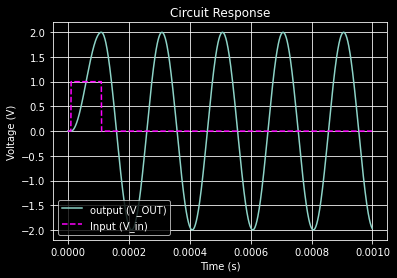

Example plot for an LC circuit voltage input from a 1.0V step pulse, showing the resulting sinusoidal oscillations.

## LC Circuit as a Solver

Recall that the RC circuit discussed earlier acts as a low pass filter or leaky integrator of a specific form of first-order ODE. In other words, it computes a time-weighted average of the input signal and smooths out its variance when noise is present, modeling accumulation with decay. It is capable of solving an analog equation of the form: 

$$
\frac{dy}{dt}= a(x(t)-y(t)
$$

The LC circuit models harmonic oscillation, and is capable of solving an analog equation of the form: 

$$
\frac{d^2y}{dt^2} + \omega_0^2 \, y = 0 
$$

As an example, this simple circuit can be used to simulate the behavior of an idealized (frictionless) newtonian mass spring system. 

From newton's law: Force = Mass x Acceleration. In other words, 

$$
\frac{d^2x}{dt^2} = \frac{F}{M}
$$

According to [Hooke's law](https://en.wikipedia.org/wiki/Hooke's_law), $F = -\kappa\,x$ where $k$ is a spring constant in $N/m$ and x is the position of the mass. Force is negatively proportional to $\kappa\,x$ in this force relation because the restoring force of the spring tends to work in the opposite direction of displacement (resisting movement). So, rearranging gives: 

$$
M\,\frac{d^2x}{dt^2} + \kappa\,x = 0 
$$

Dividing through by M gives: 

$$
\frac{d^2x}{dt^2} + \frac{\kappa}{M}x = 0 
$$

This is close to our circuit's behavior. Let $\omega_0 = \sqrt{\frac{\kappa}{M}}$. 

From our previous section, we have: 

$$
\frac{d^2V_C}{dt^2} + \frac{1}{L\,C}\, V_C = 0
$$

If the circuit is set up so that $\frac{1}{L\,C} = \frac{\kappa}{M}$, or written in a more straightforward way $L\,C=\frac{M}{\kappa}$ Then it follows that the voltage across the capacitor approximately equals the displacement at time (t), 

$$
V_C(t) \approx x(t)
$$

In the analog emulator, we can use a single pulse voltage input to simulate adding energy to the system (like pushing or pulling on the the mass and releasing). But to do that we need to relate the amplitude and duration of the voltage pulse to the energy added to the system so that this initial conditions is also analogous to the physical problem being modeled by the LC circuit. 

---

### Determining the Initial Condition

Suppose we have a mass M of $0.5 kg$, and a spring constant of $\kappa= 4\,N/m$, then $\omega_0^2 = 8$ and $LC = \frac{1}{8} \approx 0.125$. Any LC equaling $0.125$ will work, so for example, we'll try: $L=0.25\,H$ and $C= 0.5\,F$. 

Now supporse we apply a voltage pulse from the input source across the inductor to start the oscillations. Recall that, 

$$
V_{L(t)}= L\,\frac{di(t)}{dt}
$$

The voltage pulse has an amplitude and a time duration. The injected current will charge the inductor, and begin oscillating with the capacitor. We monitor the voltage across the capacitor to see the oscillations. So, we need to choose the amplitude ($A$) and duration ($\Delta\,t$) to match the total displacement we want to simulate by rapidly pushing the mass. Recall from above that the displacement at time (t) is proportional to the voltage across the capacitor, $V_C(t) \approx x(t)$. More appropriately, $\alpha\,V_C(t) \approx x(t)$, where $\alpha$ is a proportionality constant that relates the voltage to desired length units. 

In order to choose $A$ and $\Delta\,t$, we need to know how much current is injected during that time, assuming $i(0)=0$. 

$$
\int_{0}^{\Delta\,t}\,V_{L(t)}\,dt = \int_{0}^{\Delta\,t}\,L\,\frac{di(t)}{dt}dt = L\,\int_{0}^{\Delta\,t}\frac{di(t)}{dt}dt  
$$

Evaluating we have, 

$$
L\,\int_{0}^{\Delta\,t}\frac{di(t)}{dt}dt = L\,(i(\Delta\,t) - i(0))
$$

Because we assume $i(0)=0$, we have

$$
L\,\int_{0}^{\Delta\,t} V_L(t)dt = L\,i(\Delta\,t)
$$

Now assume that $V_L(t) = A$ for $\,0 \leq\, t \leq \, \Delta(t)$, 

$$
\int_{0}^{\Delta\,t} Adt = A\,i(\Delta\,t)
$$

so we have

$$
A\,i(\Delta\,t) = L\,i(\Delta\,t) 
$$

and 

$$
i\Delta(t)= \frac{A\,\Delta\,t}{L}
$$

now relating this to the voltage across the capacitor,

$$
\frac{dV_C}{dt}(0)= \frac{i(0)}{C}= \frac{A\,\Delta\,t}{LC}
$$

and finally to displacement,

$$
\frac{dx}{dt}(0) = \alpha\,\cdot\,\frac{A\,\Delta\,t}{LC}
$$

This will give us the velocity ($\nu$) in $m/s$ for the initial pulse as long as the mass starts at rest and there is no current in the circuit already. 

---

In our example we used $L\,C= 0.125 s^2$. If we set $A= 1.0 V$ and $\Delta(t)= 0.1 s$ our units come out to $V/s$. Recall that $x(t) \approx \alpha\cdot\,V_C(t)$. $\alpha$ has units of $m/V$. For example, if we choose alpha to be $10^{-2}\,m/V$, the displacement of the initial push is $0.008 m$. 

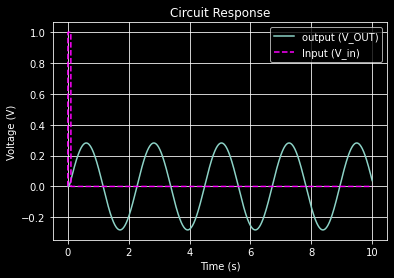

Here is a plot of the scoped output at the capacitor using a 1.0 V pulse of .001 s duration. The voltage can be scaled to position by multiplying by .01. 

---

### A Physical Note

The frequency of the oscillations in an ideal system will remain constant, because these are determined by the spring constant and the mass, which do not change. Changing the LC constant in this circuit (by modifying the hardware components) would change the frequency, but should be done in proportion to the spring constant and mass being modeled.  

If a real mass-spring system is pushed, the amplitude of the oscillations would decrease over time, eventually returning to a state of no motion because the real system experiences two forces that determine the displacement as a function of time: 

1. the returning force of the spring
2. the resistive [friction force](https://en.wikipedia.org/wiki/Friction) acting on the mass

An LC circuit cannot model this, because there is no way to incorporate a decay rate on the oscillations. In order to extend this physical system's simulating ability to model more than one force, we need to add another hardware component - a resistor.

---

### Bio Note

The LC circuit produces oscillations becasue the inductor and capacitor each store potential energy, but each does this in different ways. In biological systems, lipid bilayer membranes in conjuction with macromolecular ion channels, transporters, or ionophores act as direct manifestations of capacitors. To the best of my knowledge, there is no direct analog to inductors, which store potential energy in a magnetic field. 

Harmonic oscillations do occur in biology, and are extremely important. For example, oscillating intracellular free calcium is an important control mechanism for regulating enzyme activities. The thing to learn from this idealized LC circuit, is that oscillations don't just happen. The conditions that create them involve two physical systems capable of storing and exchanging energy with a time delay. In a cell, this may involve calcium entering and leaving at the plasma membrane combined with calcium entering and leaving the endoplasmic reticulum. These two processes may mirror each other with a time delay because the are connected via the matter and energy flows in the cytoplasm. The particulars of the oscillatory behavior will depend on the nature of the time delay - e.g., are they mirrored, synchronous, in phase, out of phase, etc. 

I think it's incredibly important that oscillations can occur between two capacitors (in biological systems) as well as between an inductor and capacitor in a LC circuit. It implies something fundamental about how physical systems manage to form the same patterns despite being different processes altogether. Mathematics, a language of operations, enable us to formally describe the analagous behavior of most physical systems. 

## Mathematics Note

But WHY? Why is does an LC circuit behave similarly to a frictionless mass-spring system? They're completely different types of systems after all! The answer, it seems, is because they share the same mathematics. Perhaps on a deeper level, we can say that they share the same [operations](https://en.wikipedia.org/wiki/Operation_(mathematics)). Commonality among operations may serve as the root cause of [multiple realizability](https://en.wikipedia.org/wiki/Multiple_realizability). In other words, for certain sets physical systems, there may be a many-to-one mapping from physical states to observable system states. One interesting natural example is the non-homologous evolution of wings (i.e., butterfly wings, bat wings, and bird wings are implementations of the same class of flight supporting-appendage but implemented on different hardware and in different ways). Word processor programs are a technological examples. These programs can be implemented on many different types of hardware (i.e. mechanical typewriter, digital computer, lego turing machine, etc). Let's make this idea more explicit for our current hardware. 


---

### The Capacitor

A capacitor is two conductors separated by a [dielectric](https://en.wikipedia.org/wiki/Dielectric). When charge is moved onto one side, work is done against the electric field and energy is stored. The amount of energy is: 

$$
E_C= \frac{1}{2}\,C\,V_C^2
$$

where C is the capacitance, which is proportional to the dielectric constant (tendency to reject charged particles in the separating material). One way to think about this is that the capacitor stores energy when the charge is 'displaced'. 

A spring on the other hand, is a coiled piece of metal wire. It resists being pulled longer or pushed shorter from its initial length. This is known as return force, which is proportional to its spring constant $\kappa$. If the spring is squished shorter by some length, the amount of energy is: 

$$
E_{spring}= \frac{1}{2}\kappa\,x^2
$$

where x is the position of one of the ends of the spring in the 'x' dimension (chosen as a reference). 

See the similarity? both of these physical systems behave as linear restorers. That is $\text{Charge}(Q)=C\,V_C$ and $\text{Return Force}(F)= -\kappa\,x$. In practice, with choice of appropriate scaling coefficients, $V_{C}(t) \propto x(t)$. 

Bottom line ... you can store energy in a spring by squishing it along its longitudinal axis, and you can store energy in a capacitor by charging it. These two things behave the same way in ideal terms and can be [scaled](https://en.wikipedia.org/wiki/Scaling_(geometry)) to one another simply by changing units.

---

### The Inductor

Inductors resist changes in current by conducting through a magnetic field. A mass attached to the spring resists changes in motion due to [inertia](https://en.wikipedia.org/wiki/Inertia). 

$$
V_L= L\,\frac{di}{dt}
$$

and,

$$
F=M \frac{dv}{dt}
$$

With these two concepts in mind, we use each system to simulate the behavior of the other by anology. However, we are limited to ideal conditions in which there is no resistance in the circuit and no friction working against the mass connected to the spring. How can we add resistive force to the circuit? We'll use a resistor!

## The Resistor Inductor Capacitor (RLC) Circuit

The LC circuit can only serve as an analog to the fricionless mass-spring system. The inductor simulates inertial force of the mass and the capacitor simulates the return force of the spring. To simulate the effects of an additional force (i.e. friction), we need another hardware component. Luckily, we've already seen this component, the resistor! 

The setup looks like this: 

V_+ -> R1 -> L (Inductor) -> V_OUT (Oscilloscope) -> C (Capacitor) -> GND

---

### The Resistor

A resistor drops voltage in proportion to current. Recall that current $i(t)$ is the time derivative of charge $\frac{dq}{dt}$, and charge is stored voltage. Storing voltage requires capacitance, so $Q=C\,V_C$. 

$$
V_R= R\,i= R\,\frac{dq}{dt}
$$

Friction exerts a force proportional to velocity. 

$$
F_{friction}= \beta\,\nu= \beta\,\frac{dx}{dt}
$$

Returning to the descriptions we've seen previously, recall from KVL that:

$$
V_R(t) + V_L(t) + V_C(t) = 0
$$

We can express in general terms by $y=V_C$, the voltage across the capacitor where we are monitoring with the scoped output. Recall that the current in the circuit is: 

$$
i(t)= C\frac{dy}{dt}
$$

So for each component:

$$
\text{Resistor:}\, V_R(t)= R\,i(t)= R\,C\,\frac{dy}{dt}
$$

$$
\text{Inductor:}\, V_L(t)= L\,\frac{di}{dt} = L\,\frac{d}{dt}(C\,\frac{dy}{dt})= L\, C\, \frac{d^2y}{dt^2}
$$

$$
\text{Capacitor:}\, V_C(t) = y(t)
$$

Putting these together we have: 

$$
L\, C\, \frac{d^2y}{dt^2} + R\,C\,\frac{dy}{dt} + y(t) = 0
$$

Dividing through by $LC$, we have: 

$$
\frac{d^2y}{dt^2} + \frac{R}{L}\,\frac{dy}{dt} + \frac{1}{LC}\,y(t) = 0
$$

Now, let $a=\frac{R}{L}$, and $b= \frac{1}{LC}$. This gives us the general form: 

$$
\frac{d^2y}{dt^2} + a\frac{dy}{dt} + b\,y = 0
$$

So, our RLC circuit is capable of behaving like ANY system that also shares this set of operations. This second order differential equation can model any resonant system with decay. This includes damped oscillations like the more realistic mass-spring system with friction forces accounted for. 

## RLC Circuit as a Solver

Returning to the mass-spring system. Earlier we began with Newton's law: 


$$
\frac{d^2x}{dt^2} = \frac{F}{M}
$$

We will now account for both the return force of the spring and the resistive force of friction, so the total force is the sum of these two forces: 

$$
F_{Total}= F_{Return} + F_{Friction}
$$

The return force depends on the properties of the spring and how far the position is from neutral. 

$$
F_{Return} = -\kappa\,x
$$

The friction force increases in proportion with velocity. 

$$
F_{Friction}= -\beta\,\frac{dx}{dt}
$$

From above, 

$$
\frac{d^2x}{dt^2} = \frac{- \beta\,\frac{dx}{dt} - \kappa\,x}{M}  
$$

Now we just need to rearrange a bit to get this into the form of equation our circuit can solve. 


$$
M\,\frac{d^2x}{dt^2} + \beta\,\frac{dx}{dt} + \kappa\,x = 0 
$$

Dividing through by M gives: 

$$
\frac{d^2x}{dt^2} + \frac{\beta}{M}\,\frac{dx}{dt} + \frac{\kappa}{M}x = 0 
$$

This gives us the familiar form:

$$
\frac{d^2y}{dt^2} + a\frac{dy}{dt} + b\,y = 0
$$

Now, let $a=\frac{R}{L}$, and $b= \frac{1}{LC}$. This gives us the general form: 

$$
\frac{d^2V_C}{dt^2} + \frac{R}{L}\,\frac{dV_C}{dt} + \frac{1}{LC}\,V_C(t) = 0
$$

Recall from earlier that $\frac{1}{LC}$ is proportional to the angular resonant frequency. Its actual value, set by the hardware, will determine how often the oscillations occur. The new term $\frac{R}{L}$  is proportional to the damping coefficient ($\beta$), and will determine how the amplitude of the oscillations change over time. If undamped the oscillations will not decay (as in the ideal frictionless scenario). If underdamped the amplitude will decay exponentially with time. If critically damped, the amplitude will decay toward zero without oscilating. The critically damped state has fastest return to zero. If overdamped the amplitude will decay toward zero at some rate that is slower than the critically damped case without oscillating.  

---

### Mathematics Note

We can estimate the values of resistance that will cause each of these three scenarios by using some mathematical properties of homogeneous linear ordinary differential equations (with constant coeffients). These are of the general form: 

$$
a\,\frac{d^2y}{dt^2} + b\frac{dy}{dt} + c\,y = 0
$$

We can assume that the solution of $y(t)$ is $e^{s\,t}$ for [math reasons](https://en.wikipedia.org/wiki/Characteristic_equation_(calculus)) that have been well-demonstrated for this sort of equation but that I won't expand on here. Note also that if:  

$$
f(t)= e^{st}
$$

then the first derivative is: 

$$
\frac{d(e^{st})}{dt}= s\,e^{st}
$$

and, 

$$
\frac{d^2(e^{st})}{dt^2}= s^2\,e^{st}
$$
We can use this rule for differentiaion of our characteristic equation above:

$$
a\, s^2\,e^{st} + b\,s\,e^{st} + c\,e^{st} = 0
$$

Next we factor the $e^{st}$ term: 

$$
e^{st}(a\, s^2\, + b\,s + c) = 0
$$

This makes a second degree polynomial in terms of $s$. Using the [quadric formula](https://en.wikipedia.org/wiki/Quadratic_formula) we can find the roots. Substituting for our circuit coefficients we have: 

$$
e^{st}(s^2\, + \frac{R}{L}\,s + \frac{1}{LC}) = 0
$$

The $e^{st}$ term never goes anywhere so we can simple solve the quadratic equation to find the resistance conditions for different modes of behavior. 

The system will be undamped if: 

$$
R = 0
$$

The system will be underdamped if: 

$$
R^2 < 4\frac{L}{C}
$$

Critically damped if: 

$$
R^2= 4\frac{L}{C}
$$

And overdamped if: 

$$
R^2 > 4\frac{L}{C}
$$


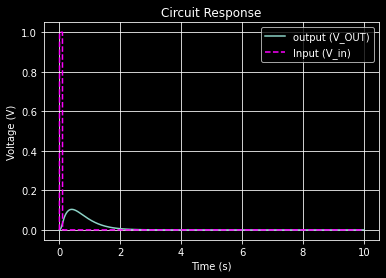

Figure 1: a Critically overdamped oscillation (Resistance = $\sqrt{2}$ Ohms

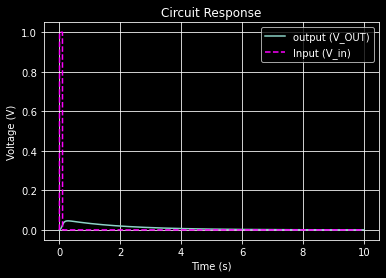

Figure 2: An overdamped oscillation (Resistance = $4$ Ohms

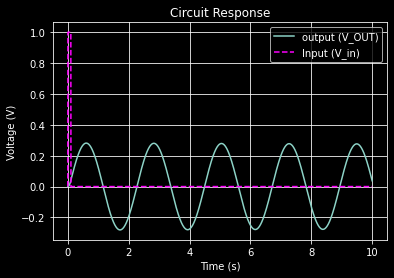

Figure 3: Underdamped (Resistance = $10^{-3}$ Ohms

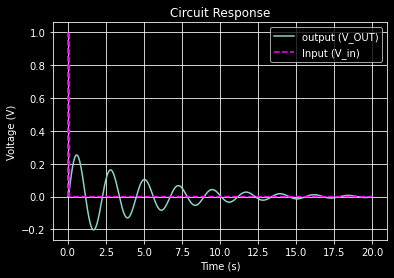

Figure 4: Between underdamped and critically overdamped (Resistance = $10^{-1}$ Ohms

## Circuits with Diodes

We are close to being able to make powerful integrated circuits, but first need to modify the program to incorporate passive and active nonlinear components. We'll start with the diode because diodes are part of transistors. So having a diode component class will enable use to build the transistor class in a more modular way. 

Recall from earlier that a [diode](https://en.wikipedia.org/wiki/Diode) is a two terminal device that conducts current primarily in one direction. Diodes have an [exponential current-voltage (I-V)](https://en.wikipedia.org/wiki/Current%E2%80%93voltage_characteristic) relationship. 

A simple testing setup looks like this (with voltage scoped at the diode node):

V_IN -> R(Resistor) -> D(Diode) -> GND

---

### Some Relevant Physical Relations

The diode introduces a nonlinear directional constraint on current flow. This behavior is described by the [Shockley diode equation](https://en.wikipedia.org/wiki/Shockley_diode_equation):

$$
I_D(V_D)= I_S\,(e^{\frac{V_D}{n\,V_t}}-1)
$$

where $I_D$ is the diode current. $I_S$ is the reverse-bias saturation current. $V_D$ is the voltage across the diode. Note that $I_D(V_D)$ is not a product, but is expressing diode current as a nonlinear function of voltage across the diode. $n$ is the ideality, which varies from $1 \leq n \leq 2$. $V_t$ is the thermal voltage. It has the relation: 

$$
V_t= \frac{k\,T}{q}
$$

where $k$ is [Boltzmann's constant](https://en.wikipedia.org/wiki/Boltzmann_constant), $T$ is absolute temperature (Kelvin), and $q$ is the [elementary charge](https://en.wikipedia.org/wiki/Elementary_charge). This is important because it indicates that $I_D$ varies (in part) as a function of temperature, which should be accounted for when simulating more realistic circuit behaviors and limitations.  

---

### Solving with Nonlinearity

In the emulator program, the current and voltage at each timestep are given by a straight line. We 'stamp' the matrix ($G\cdot\,x=I$) with the currents and voltages, and then repeat this iteratively over time to see the time-dependent dynamics of the circuit. This isn't necessarily the case for the diode, which has a nonlinear relationship between current and voltage, but we're including it inside a system of linear equations with the other components. Math note: The rate of change (i.e., slope) of a linear equation is a single number. The rate of change of a nonlinear equation is best described by one or more equations. We can't solve a nonlinear equation inside of a system of linear equations. 

We must get around this mathematically by making a [linear approximation](https://en.wikipedia.org/wiki/Linear_approximation) of the slope at each timestep so that we can write the nonlinear terms that describe the diode behavior as linear terms. We do that using the [Newton-Raphson method](https://en.wikipedia.org/wiki/Newton's_method). This method makes the stamped voltage at the previous step as an 'operating point' and computes the slope of the tangent line at that point. To minimize error, our emulator algorithm repeats this several times at each time step by feeding the estimated slope back into the method until the variation becames smaller than a pre-designated residual error cutoff. 

Here's an example, suppose we set up the circuit V_in -> R(Resistor) -> D(Diode) -> GND. Let V_in=1.0 V, R = 1000 $\,\Omega$, $I_S = 1\cdot10^{-12} A$, $n=1.0$, and $V_T=25\cdot10^{-3}$. From Kirchoff's laws: 

The voltage drop across R is:

$$
V_R= V_{IN} - V_D
$$

The current through R and the diode is:
$$
I= \frac{V_{IN}-V_D}{R} = I_D(V_D)
$$

Subsituting the Shockley diode equation for $I_D(V_D)$: 

$$
\frac{1.0-V_D}{1000}= I_S(e^{\frac{V_D}{V_t}}-1)
$$

Now for the Newton_Raphson iteration, define:

$$
f(V_D)= \frac{1.0-V_D}{1000} - I_S(e^{\frac{V_D}{V_t}}-1) 
$$

Differentiating by parts, we have,

$$
\frac{d}{dV_D}(\frac{1.0-V_D}{1000})= -\frac{1}{1000} 
$$

and,

$$
\frac{d}{dV_D}(I_S(e^{\frac{V_D}{V_t}}-1))=\frac{I_S}{V_t}\cdot\,e^{\frac{V_D}{V_t}}  
$$

putting this together we have the derivative, which gives us the slope of the error function: 

$$
f'(V_D)= -\frac{1}{1000} - \frac{I_S}{V_t}\cdot\,e^{\frac{V_D}{V_t}}
$$

The emulator program will choose an operating point based on the voltage at the previous step (or initial condition in the first step). Here we'll arbitrarily choose this value as though the previous step was 0.7 V for demonstration. 

$$
e^{\frac{V_D}{V_t}} = e^{\frac{0.7}{.025}} = 1.446\cdot10^{12}
$$

The diode current Shockley equation is:

$$
I_D(V_D)= I_S\,(e^{\frac{V_D}{n\,V_t}}-1)= 10^{-12}\,(1.446\cdot10^{12}-1) \approx 1.446 A
$$

Using Ohm's law we have,

$$
I_R= -\frac{V_{in}-V_D}{1000}= \frac{1.0-0.7}{1000}= .0003 A
$$

The difference between the resistor and diode currents is:

$$
f(0.7)= .0003-1.446= -1.447 A
$$

which gives us the slope of the diode current function at $V_D=0.7\,V$,

$$
g_d = \frac{I_S}{V_t} \cdot e^{\frac{V_D}{V_t}} = \frac{10^{-12}}{0.025} \cdot 1.446 \cdot 10^{12} \approx 57.84
$$

We can get the slope of the residual error function $f'(V_D)$, 

$$
f'(0.7)= -\frac{1}{1000} - g_d = -0.001 - 57.84 = -57.841
$$ 

Now we can compute the correction:

$$
\Delta(V_D)= \frac{-f(V_D)}{f'(V_D)}= \frac{1.4457}{57.841}\approx 0.025 V
$$

we now update our guess, 

$$
V_D^{(1)}= 0.7 + 0.025= 0.725 V
$$

With our oupdated guess, we would then feed that guess back into the algorithm, calculating $f(0.725)$. The difference in values each iteration will get smaller and smaller, and we stop when that difference drops below $10^{-6}$ (in the emulator). This method works as long as: 

1. The function is continuous and differentiable
2. $f'(V_D)$ isn't zero
3. The initial guess is reasonably close

---

### Returning to the Physical Relation

Once we've approximated the slope we can now write our diode equation in linear terms, well call it the small signal conductance $g_d^{(k)}$. Recall the Shockley diode equation from above: 

$$
I_D(V_D)= I_S\,(e^{\frac{V_D}{n\,V_t}}-1)
$$

We linearize the $I-V$ curve near the point of interest by using a [taylor series expansion](https://en.wikipedia.org/wiki/Taylor_series): 

$$
I_D(V_D)\approx\,I_D(V_D^{(k)}+ \frac{dI_D}{dV_D}(V_D^{(k)})\cdot(V_D-V_D^{(k)})
$$

This term $\frac{dI_D}{dV_D}(V_D^{(k)})$ means we're evaluating the slope where $x=(V_D^{(k)})$. This should look familiar as our $g_d^{(k)}$, which we obtained using the Newton-Raphson method above! 

So our linear approximation of the diode's behavior at each timestep is: 

$$
I_D(V_D)= I_D^{(k)} + g_d^{(k)}\cdot(V_D-V_D^{(k)}) \,\text{... phew}
$$

That's what we stamp in our MNA. 

## Circuits with Diodes as Solvers

[Diode logic gates](https://en.wikipedia.org/wiki/Diode_logic) can be implemented but are somewhat impractical (by modern standards). I'm not gonna explore this right now. Maybe there are interesting things to do with these, and maybe I'll circle back someday. For now, the real reason we made a diode component class is so we can use them in a transistor class. That will be much more interesting, because transistors are the last thing we need to start building integrated circuits for op-amps... Onward and upward! 

## Circuits with Transistors (The Common-Emitter Amplifier)

Earlier, we discussed that there are two classes of circuit components: 1) linear/nonlinear and 2) active/passive. The diode was the first nonlinear component we discussed, but the diode is also a passive component just like the resistor, inductor, and capacitor. The [transistor](https://en.wikipedia.org/wiki/Transistor) is an active nonlinear component that consists of a semiconductor material and uses an input voltage or current to modify a second voltage or input current. Transistors can reduce or amplify the input voltage or current, enabling switch-like or summative behaviors depending on the setup. There are a few different types that behave similarly, but have different underlying physics/mathematical bases. We will use a [bipolar junction transistor](https://en.wikipedia.org/wiki/Bipolar_junction_transistor) (BJT) in our emulator. 

The BJT consists of an emitter and collector connected by a base. The input current enters the emitter (a forward biased diode), moves through the base, and then out through the collector (a reverse biased diode). Recall that diodes can exhibit (ideal) zero or infinite resistance depending on the current coming into them. The base receves additional input current from a separate source, and this current controls the behavior of the current flow through the transistor. 

The basic circuit we'll study is called a [common-emmitter amplifier](https://en.wikipedia.org/wiki/Common_emitter). It consists of the following layout: 

1. VCC 

* VCC -> Rc (Collector Resistor) -> V_OUT (Scoped output) -> Q1(Collector) -> Q1(Emitter) -> Re(Emitter Resistor) -> GND

* VCC -> Rb (Base Resistor) ->  Q1 (Base) -> Q1 (Emitter) -> Re -> GND

2. Vin(t)

* Vin(t).positive -> Cin (Collector) -> Q1 (Base) -> Q1 (emitter) -> Re -> GND

* Vin(t).negative -> GND

3. Output path

* Collector -> C_OUT -> V_OUT -> GND

This is more complicated than our previous circuits. There is a diagram in the wikipage linked out above. 

---

### Some Relevant Physical Relations

Our BJT transistor consists of two diodes (p-n junctions) sharing a common base region. P and n are semiconductor materials in BJT transistors. P is positive and n is negative, made of materials acting as an anode and cathode respectively. In a charge polarized device, the anode is where conventional current leaves the device, and the cathode is where current enters the device (think positive and negative poles on a AA battery). Hence the term diode (anode and cathode in one device). When a p-n junction is added on its own to a circuit, it functions as a diode. P-n junctions can also be arranged p-n-p or n-p-n with additional current injected into the common region, obtaining more complex outputs. This specific type of hardware arrangement is the BJT transistor (n-p-n or p-n-p). In material terms, each junction consists of 'doping' semiconductor materials. For example, the p semiconductor may be doped with Boron making it more conductive. The same is true for the n semiconductor. The interface, where the two semiconductors meet becomes depleted of charge carriers (electrons) in a manner that depends on the voltage applied at each junction. The theory for this concept was laid out by Nobel prize winner [William Shockley](https://en.wikipedia.org/wiki/William_Shockley). Negative charge carriers (electrons) can easily flow from n to p, but not p to n. The former is known as forward bias, the latter negative bias. The bias is modified by the application of voltage at the junction, for example a p-n junction with no applied voltage will reach a zero equilibrium bias. 





## The Operational Amplifer and GPAC

... This section is where we are ultimately headed. I will finish this later ...

The [general purpose analog computer (GPAC)](https://en.wikipedia.org/wiki/General_purpose_analog_computer) was a mathematical model of a minimal analog computer described by [Claude E. Shannon](https://en.wikipedia.org/wiki/Claude_Shannon) in his analysis of the [differential analyzer](https://en.wikipedia.org/wiki/Differential_analyser) developed by [Vannevar Bush](https://en.wikipedia.org/wiki/Vannevar_Bush). 

An analog computer is based on the creation of a model which represents the problem to be solved. Although most (electronic) analog computers work with (quasi) continuous values (voltages in most cases), this is not a necessary condition for an analog computer. What makes an analog computer an analog computer is the fact that it resembles a model (an analog) for the problem to be solved.

Basic computing elements of an analog computer are summers, integrators, multipliers, function generators and comparators. These hardware devices are themselves analogs of fundamental operations such as multiplication, additions, inversion, etc. 

Programming an analog computer consists of the transformation of the equations describing the problem into the physical hardware in a form that behaves in an operationally equivalent way to the problem.

---

The RC circuit can solve a family of linear ODE's of the specific form we discussed above. The addition of an operational amplifier (op-amp) circuit will enable simulation of ANY first order linear ODE of the form: 

$$
\frac{dy}{dt}= a\cdot\,x(t)- b\cdot\,y(t)
$$